In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [7]:
batch_size = 50
epochs = 20
particles = 10
early_stopping = False
early_stopping_diff = 0.001
batch_normal = False # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = True

In [8]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [9]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [10]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [11]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [12]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [13]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 988us/step - loss: 2.3035 - accuracy: 0.0900


In [14]:
import time
start_time = time.time()

In [15]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
        d = np.transpose(d)                              
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
                
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    for i in range(particles):
        # for every particle write the training accuracy of the current iteration in a dictionary
        train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_train, y_train, verbose = 0)[1])

        # for every particle write the test accuracy of the current iteration in a dictionary
        test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_test, y_test, verbose = 0)[1])

        # for every particle write the current iteration in a dictionary
        iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new

In [16]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 170.36934542655945


In [17]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 935us/step - loss: 277.3723 - accuracy: 0.2440
0.24400000274181366
16/16 [==============================] - 0s 1ms/step - loss: 248.6304 - accuracy: 0.2660
0.26600000262260437
16/16 [==============================] - 0s 1ms/step - loss: 254.4627 - accuracy: 0.2560
0.25600001215934753
16/16 [==============================] - 0s 1ms/step - loss: 257.5883 - accuracy: 0.2540
0.2540000081062317
16/16 [==============================] - 0s 1ms/step - loss: 265.5790 - accuracy: 0.2660
0.26600000262260437
16/16 [==============================] - 0s 1ms/step - loss: 249.2632 - accuracy: 0.2640
0.2639999985694885
16/16 [==============================] - 0s 935us/step - loss: 253.9575 - accuracy: 0.2640
0.2639999985694885
16/16 [==============================] - 0s 1ms/step - loss: 248.8726 - accuracy: 0.2680
0.2680000066757202
16/16 [==============================] - 0s 1ms/step - loss: 254.4357 - accuracy: 0.2580
0.257999986410141
16/16 [==============

In [18]:
model_dict

{'model_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x101c3eeb248>,
 'model_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x101c3ffc288>,
 'model_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x101c402e288>,
 'model_4': <tensorflow.python.keras.engine.sequential.Sequential at 0x101c405e3c8>,
 'model_5': <tensorflow.python.keras.engine.sequential.Sequential at 0x101c408f748>,
 'model_6': <tensorflow.python.keras.engine.sequential.Sequential at 0x101c508fa88>,
 'model_7': <tensorflow.python.keras.engine.sequential.Sequential at 0x101c50bedc8>,
 'model_8': <tensorflow.python.keras.engine.sequential.Sequential at 0x101c50f6048>,
 'model_9': <tensorflow.python.keras.engine.sequential.Sequential at 0x101c5124408>,
 'model_10': <tensorflow.python.keras.engine.sequential.Sequential at 0x101c5150408>}

In [19]:
model_dict["model_1"].get_weights()

[array([[ 0.05880399, -0.02307576, -0.05036016, ...,  0.46403265,
          0.07074289, -0.08254398],
        [ 0.03327464,  0.09709829,  0.03607357, ...,  0.01132859,
         -0.22910385,  0.05533279],
        [-0.1352622 ,  0.39414975,  0.12656273, ..., -0.11467211,
          0.03079184, -0.01232197],
        ...,
        [ 0.2422012 , -0.13310122, -0.0638892 , ..., -0.2687199 ,
          0.14042494,  0.11290298],
        [-0.20116526,  0.04104648, -0.1302514 , ..., -0.04877881,
          0.16198082,  0.32126167],
        [-0.2567821 ,  0.0238016 ,  0.05979377, ...,  0.00121618,
          0.16636753, -0.18626384]], dtype=float32),
 array([ 0.24939695, -0.04029753,  0.00493666,  0.12077129, -0.11811566,
        -0.09939247, -0.23324232,  0.02715265,  0.04307879,  0.15020871,
        -0.00437815, -0.17101516, -0.07815976,  0.09482391, -0.06300568,
        -0.04996694, -0.09050414,  0.0121098 ,  0.0633103 , -0.02558311,
         0.08636597, -0.15271994,  0.33466798,  0.15684406,  0.021

In [20]:
y_pred_dict["model_1"]

array([[1.0000000e+00, 0.0000000e+00, 1.6920873e-30, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.2270326e-35, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.8956909e-08, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.00

In [21]:
jacobian_dict["model_1"]

array([[  -0.        ,   -0.        ,   -0.        , -200.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        , -200.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        , -200.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.99502486,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        , -200.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0

In [22]:
print(mean_model_train_acc)
print(mean_model_test_acc)

[0.093      0.131      0.13       0.168      0.18700001 0.18799999
 0.22499999 0.185      0.21600001 0.207      0.243      0.237
 0.255      0.25099999 0.29499999 0.27900001 0.301      0.29499999
 0.27399999 0.29800001 0.30599999]
[0.09       0.098      0.11       0.13       0.18000001 0.134
 0.184      0.198      0.20999999 0.212      0.236      0.22400001
 0.234      0.19599999 0.22400001 0.23800001 0.27399999 0.28
 0.244      0.244      0.25999999]


In [23]:
train_acc_dict

{'model_1': [0.08500000089406967,
  0.10000000149011612,
  0.164000004529953,
  0.1860000044107437,
  0.1770000010728836,
  0.19599999487400055,
  0.1850000023841858,
  0.20600000023841858,
  0.23000000417232513,
  0.24199999868869781,
  0.2639999985694885,
  0.2630000114440918,
  0.2720000147819519,
  0.30000001192092896,
  0.28299999237060547,
  0.3160000145435333,
  0.30000001192092896,
  0.3059999942779541,
  0.29499998688697815,
  0.2919999957084656],
 'model_2': [0.10599999874830246,
  0.11599999666213989,
  0.16899999976158142,
  0.16200000047683716,
  0.21699999272823334,
  0.19300000369548798,
  0.21199999749660492,
  0.21199999749660492,
  0.23399999737739563,
  0.25,
  0.2460000067949295,
  0.26100000739097595,
  0.27399998903274536,
  0.2939999997615814,
  0.2930000126361847,
  0.32600000500679016,
  0.2980000078678131,
  0.3190000057220459,
  0.3050000071525574,
  0.30399999022483826],
 'model_3': [0.09200000017881393,
  0.12300000339746475,
  0.16599999368190765,
  0.1570

In [24]:
test_acc_dict

{'model_1': [0.10599999874830246,
  0.0860000029206276,
  0.1080000028014183,
  0.15000000596046448,
  0.1459999978542328,
  0.20000000298023224,
  0.22200000286102295,
  0.23199999332427979,
  0.23199999332427979,
  0.23399999737739563,
  0.2280000001192093,
  0.22599999606609344,
  0.1899999976158142,
  0.22200000286102295,
  0.24199999868869781,
  0.24799999594688416,
  0.30799999833106995,
  0.27799999713897705,
  0.2680000066757202,
  0.24400000274181366],
 'model_2': [0.09000000357627869,
  0.10999999940395355,
  0.14399999380111694,
  0.14000000059604645,
  0.14800000190734863,
  0.18000000715255737,
  0.20399999618530273,
  0.21799999475479126,
  0.23600000143051147,
  0.25200000405311584,
  0.21199999749660492,
  0.21799999475479126,
  0.20800000429153442,
  0.23199999332427979,
  0.23800000548362732,
  0.2639999985694885,
  0.30399999022483826,
  0.28200000524520874,
  0.26600000262260437,
  0.26600000262260437],
 'model_3': [0.07999999821186066,
  0.10999999940395355,
  0.12

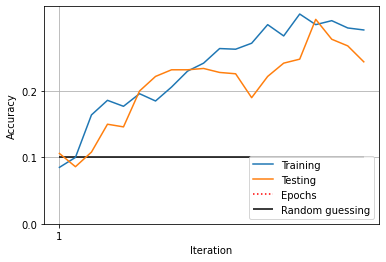

In [25]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

## Wir versuchen das gleiche mit der (falschen?) Jacobi-Matrix aus Tensorflow

In [26]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [27]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [28]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 1ms/step - loss: 2.3085 - accuracy: 0.0800


In [29]:
import tensorflow as tf

loss_fct = tf.keras.losses.CategoricalCrossentropy(reduction = "none")

In [30]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            y_batch_tf = tf.constant(y_batches[b])
            y_pred_tf = tf.Variable(y_pred_dict["model_{}".format(str(i+1))])
            
            with tf.GradientTape() as tape:
                loss_value = loss_fct(y_batch_tf, y_pred_tf)
            jacobian_tf = tape.gradient(loss_value, y_pred_tf)
            
            jacobian_dict["model_{}".format(str(i+1))] = jacobian_tf.numpy()
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
        d = np.transpose(d)                               
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
                
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new

In [31]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 2ms/step - loss: 551583.3750 - accuracy: 0.0840
0.08399999886751175
16/16 [==============================] - 0s 2ms/step - loss: 1919741.8750 - accuracy: 0.0820
0.0820000022649765
16/16 [==============================] - 0s 2ms/step - loss: 28761.5352 - accuracy: 0.0720
0.07199999690055847
16/16 [==============================] - 0s 2ms/step - loss: 48472.5469 - accuracy: 0.0960
0.09600000083446503
16/16 [==============================] - 0s 2ms/step - loss: 74206.8047 - accuracy: 0.0780
0.07800000160932541
16/16 [==============================] - 0s 2ms/step - loss: 28875.9141 - accuracy: 0.0820
0.0820000022649765
16/16 [==============================] - 0s 2ms/step - loss: 30013.9355 - accuracy: 0.1000
0.10000000149011612
16/16 [==============================] - 0s 2ms/step - loss: 22620.1133 - accuracy: 0.0840
0.08399999886751175
16/16 [==============================] - 0s 2ms/step - loss: 20643.9043 - accuracy: 0.0720
0.07199999690055847


In [32]:
model_dict["model_1"].get_weights()

[array([[-0.42239916,  0.8005475 , -1.4087508 , ..., -0.7609281 ,
          0.5627586 , -0.69301337],
        [-0.17370723, -0.15058137,  0.7740332 , ..., -0.20599169,
          1.664789  ,  0.7371624 ],
        [ 1.0436591 ,  0.11962429, -1.0318134 , ..., -0.75178665,
          0.27802387, -0.7346355 ],
        ...,
        [-1.2787385 ,  1.2356955 ,  1.1140653 , ..., -0.18138409,
          0.9530906 , -1.3229272 ],
        [-0.68961203,  0.4567506 ,  0.6816287 , ...,  2.0223277 ,
          0.97592056,  0.444298  ],
        [-0.79630154, -0.33002064, -0.96423125, ..., -0.04849152,
          0.39338595, -0.0507733 ]], dtype=float32),
 array([ 0.11668102,  0.3628046 , -0.33944377, -0.6069126 , -0.55484587,
        -0.5442541 ,  0.01042476, -0.06026702, -0.60200983, -0.520848  ,
         0.51917386,  0.05486967,  0.24589403,  0.9023477 ,  0.7628325 ,
         0.6967145 ,  0.18179996, -0.21474849, -0.27120596, -0.50832427,
        -0.3732139 ,  0.76375073,  0.6701593 ,  0.3366921 , -0.242

In [33]:
y_pred_dict["model_1"]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 

In [34]:
jacobian_dict["model_1"]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

In [35]:
print(mean_model_train_acc)
print(mean_model_test_acc)

[0.087 0.104 0.067 0.078 0.1   0.122 0.112 0.122 0.103 0.133 0.061]
[0.08  0.11  0.056 0.08  0.082 0.082 0.092 0.106 0.088 0.12  0.062]


In [36]:
train_acc_dict

{'model_1': [0.07900000363588333,
  0.09700000286102295,
  0.0989999994635582,
  0.0989999994635582,
  0.09799999743700027,
  0.09799999743700027,
  0.0989999994635582,
  0.10000000149011612,
  0.0989999994635582,
  0.0989999994635582,
  0.09799999743700027,
  0.10000000149011612,
  0.0989999994635582,
  0.10000000149011612,
  0.09399999678134918,
  0.0949999988079071,
  0.09300000220537186,
  0.09300000220537186,
  0.09000000357627869,
  0.09099999815225601,
  0.08500000089406967,
  0.11599999666213989,
  0.10700000077486038,
  0.10499999672174454,
  0.10100000351667404,
  0.10499999672174454,
  0.10599999874830246,
  0.1120000034570694,
  0.10999999940395355,
  0.11100000143051147,
  0.1120000034570694,
  0.12700000405311584,
  0.10300000011920929,
  0.10599999874830246,
  0.10300000011920929,
  0.10199999809265137,
  0.0989999994635582,
  0.08299999684095383,
  0.12099999934434891,
  0.11500000208616257,
  0.08100000023841858,
  0.09200000017881393,
  0.1379999965429306,
  0.0869999

In [37]:
test_acc_dict

{'model_1': [0.09799999743700027,
  0.10000000149011612,
  0.1080000028014183,
  0.1080000028014183,
  0.1080000028014183,
  0.10999999940395355,
  0.1080000028014183,
  0.1080000028014183,
  0.10999999940395355,
  0.10599999874830246,
  0.1080000028014183,
  0.10999999940395355,
  0.10400000214576721,
  0.10999999940395355,
  0.10199999809265137,
  0.10599999874830246,
  0.10199999809265137,
  0.09200000017881393,
  0.09200000017881393,
  0.09399999678134918,
  0.07800000160932541,
  0.1080000028014183,
  0.1120000034570694,
  0.09600000083446503,
  0.09399999678134918,
  0.09399999678134918,
  0.09799999743700027,
  0.09600000083446503,
  0.0820000022649765,
  0.0860000029206276,
  0.09200000017881393,
  0.14800000190734863,
  0.10400000214576721,
  0.10199999809265137,
  0.10199999809265137,
  0.10000000149011612,
  0.09200000017881393,
  0.0820000022649765,
  0.1120000034570694,
  0.11400000005960464,
  0.06599999964237213,
  0.0820000022649765,
  0.11400000005960464,
  0.112000003

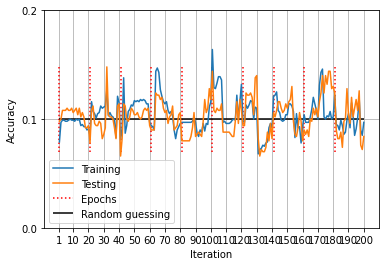

In [38]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)